## 1 environment setup

### 1.1 dependency

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import time

### 1.2 connect to machine

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


/home/enchou/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## 2 Functions

### 2.1 Generate training samples

In [3]:
def sample(N):
    global x
    x = torch.zeros([N, N, 2]).to(device)
    for i in range(N):
        for j in range(N):
            x[i][j][0] = i; # x
            x[i][j][1] = j; # y
    x.requires_grad = True

### 2.2 Generate benchmark solution

In [4]:
def compute_FD(N, Pe, w, tol = 1e-6):
    global Tn
    Tn = np.zeros((N, N))
    Tn[:, N - 1] = 1
    Tn[0, :] = 1
    
    h = 1 / (N - 1)
    iteration = 0
    res = 1
    
#     tol = h^4*0.01
    print("tol: ", tol)
    
    while(res > tol):
        iteration = iteration + 1
        res = 0
        for i in range(1, N - 1):
            for j in range(1, N - 1):
                prev = Tn[i, j]
                Tn[i, j] = Tn[i + 1 , j] + Tn[i - 1, j] + Tn[i, j + 1] + Tn[i, j - 1]
                Tn[i, j] = Tn[i, j] - 1 * Pe * (Tn[i + 1 , j] - Tn[i - 1, j] + Tn[i, j + 1] - Tn[i, j - 1]) * 0.5
                Tn[i, j] = Tn[i, j] * 0.25
                res = max(res, np.abs((Tn[i, j] - prev) / (prev + 1e-20))) 
                Tn[i, j] = prev + w * (Tn[i, j] - prev)
            
        print("iteration: ", iteration, "res: ", res)
        
    plt.subplots()[1].set_box_aspect(1)
    plt.contourf(np.transpose(Tn), vmax = Tn.max(), vmin = Tn.min(), levels = 20) #gnd_truth, PINN_out, error               
    plt.colorbar()
    
    
    fig, ax = plt.subplots(1, 1, figsize=(17,5))
    ax.plot(np.linspace(0, N - 1, N), Tn[int((N-1)/2), :], '-o')
    ax.set(xlim=(0, N))
    ax.set_box_aspect(1)
    plt.xlabel('j')
    plt.ylabel('T')
    plt.legend(['FDM', 'PINN'])
    plt.xlim((0,N-1))
    plt.ylim((0, 1))
    
    return Tn

In [5]:
##### Special case: Pe = inf
def gnd_Peinf(N):
    global Tn
    Tn = np.zeros((N, N))
    Tn[:, N - 1] = 1
    Tn[0, :] = 1
    for j in range(1, N - 1):
        Tn[j, j] = 0.5
        for i in range(1, j):
            Tn[i, j] = 1
           
    plt.subplots()[1].set_box_aspect(1)
    plt.contourf(np.transpose(Tn), vmax = Tn.max(), vmin = Tn.min(), levels = 20) #gnd_truth, PINN_out, error               
    plt.colorbar()
    
    
    fig, ax = plt.subplots(1, 1, figsize=(17,5))
    ax.plot(np.linspace(0, N - 1, N), Tn[int((N-1)/2), :], '-o')
    ax.set(xlim=(0, N))
    ax.set_box_aspect(1)
    plt.xlabel('j')
    plt.ylabel('T')
    plt.legend(['FDM', 'PINN'])
    plt.xlim((0,N-1))
    plt.ylim((0, 1))     
    return Tn

### 2.3 PINN

##### Variables on the focus:
+ N(mesh number).
+ DAB("d"imension "a"nalysis "b"ased, i.e weighing scheme):
    0. loss weight: same weight | matrix: MSE
    1. loss weight: weighted by dimension analyzed result | matrix: MSE
    2. loss weight: weighted by root of dimension analyzed result | matrix: MSE
    3. loss weight: weighted by dimension analyzed result($Pe = \infty$) | matrix: MSE
    4. loss weight: weighted by root of dimension analyzed result($Pe = \infty$) | matrix: MSE
    5. loss weight: same weight | matrix: MAE
    6. loss weight: weighted by dimension analyzed result | matrix: MAE
    7. loss weight: weighted by root of dimension analyzed result | matrix: MAE
    8. loss weight: weighted by dimension analyzed result($Pe = \infty$) | matrix: MAE
    9. loss weight: weighted by root of dimension analyzed result($Pe = \infty$) | matrix: MAE

In [6]:
def predict_NN(N, Pe, Gamma = 1, w_DE = 1, w_BC = 1, DAB = 0, start_epoch = 0, train_epoch = 50000, pl = 64):
    class Net(torch.nn.Module):
        def __init__(self, n_feature, n_hidden, n_hidden1, n_hidden2, n_hidden3, n_output):
            super(Net, self).__init__()
            self.hidden = torch.nn.Linear(n_feature, n_hidden)
            self.hidden1 = torch.nn.Linear(n_hidden, n_hidden1)
            self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
            self.hidden3 = torch.nn.Linear(n_hidden2, n_hidden3)
            self.predict = torch.nn.Linear(n_hidden3, n_output)

        def forward(self, x):
            x = torch.sin(self.hidden(x))
            x = torch.sin(self.hidden1(x))
            x = torch.sin(self.hidden2(x))
            x = torch.sin(self.hidden3(x))
            x = self.predict(x)
            return x
 
    pl_1 = 64
    net = Net(n_feature=2, n_hidden=pl, n_hidden1=pl_1, n_hidden2=pl_1, n_hidden3=pl_1, n_output=1)     # define the network
    net.to(device)
    summary(net, (1,1, 2))

    ########

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    
    loss_func = torch.nn.MSELoss()
    
    if (DAB == 5)|(DAB == 6)|(DAB == 7)|(DAB == 8)|(DAB == 9):
        loss_func = torch.nn.L1Loss()
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.8)
    plt.ion()

    ########

    if(start_epoch == 0):
        loss_epoch=[]
        loss_values = []
        loss_DE_values = []
        loss_DBC_values = []

    h = 1 / (N - 1)
    loss_op = 'mean'


    ###############################################################
    # Define loss weight                                          #
    ###############################################################

    if DAB == 0: #MSE(1)
        b = w_DE
        a = w_BC
    elif DAB == 1: #MSE(DA)
        b = w_DE /((N-1)*(N-1)*(N-1)*(N-1) * Pe * Pe)
        a = w_BC 
    elif DAB == 2: #MSE(Weak)
        b = w_DE /((N-1)*(N-1)*Pe)
        a = w_BC 
    elif DAB == 3: #MSE(DA)(inf)
        b = w_DE /((N-1)*(N-1))
        a = w_BC 
    elif DAB == 4: #MSE(weak)(inf)
        b = w_DE /(N-1)
        a = w_BC 
    elif DAB == 5: #MAE(1)
        b = w_DE #/((N-1))
        a = w_BC #/ 1
    elif DAB == 6: #MAE(DA)
        b = w_DE /((N-1)*(N-1)*Pe)
        a = w_BC 
    elif DAB == 7: #MAE(Weak)
        b = w_DE /((N-1)*(Pe**0.5))
        a = w_BC 
    elif DAB == 8: #MAE(DA)(inf)
        b = w_DE /((N-1))
        a = w_BC 
    elif DAB == 9: #MAE(Weak)(inf)
        b = w_DE /((N-1)**0.5)
        a = w_BC 
        
    ###############################################################
    # Loss weight normalization                                   #
    ###############################################################
    
    print(b, a)
    
    lambda_DE = b / (a + b)
    lambda_DBC = a / (a + b)


    ###############################################################
    # Training                                                    #
    ###############################################################

    start = time.perf_counter()
    for t in range(start_epoch, train_epoch):
        scheduler.step()
        T_out = net(x)
        T = T_out[:, :, 0]


        lap_T = (-4 * T[1:-1, 1:-1] + T[2:, 1:-1] + T[:-2, 1:-1] + T[1:-1, 2:] + T[1:-1, :-2]) / (h * h)
        Tx = (T[2:, :] - T[:-2, :])/ (h * 2) #cds
        Ty = (T[:, 2:] - T[:, :-2])/ (h * 2) #cds
    #     Tx = (T[1:-1, :] - T[:-2, :])/ (h) #up
    #     Ty = (T[:, 1:-1] - T[:, :-2])/ (h) #up
        
        if (Gamma != 0):
            loss_DE = loss_func(lap_T , (Tx[:, 1:-1] + Ty[1:-1, :]) * Pe / h)
        elif(Gamma == 0): #Pe = inf
            loss_DE = loss_func(lap_T * 0 , (Tx[:, 1:-1] + Ty[1:-1, :]))
            
        loss_DBC = loss_func(T[:, 0], torch.zeros((N , 1)).to(device)) #s
        loss_DBC = loss_DBC + loss_func(T[:, -1] - 1, torch.zeros((N , 1)).to(device)) #n
        loss_DBC = loss_DBC + loss_func(T[0, :] - 1, torch.zeros((1 , N)).to(device)) #w
        loss_DBC = loss_DBC + loss_func(T[-1, :], torch.zeros((1 , N)).to(device)) #e

        loss =  lambda_DE * loss_DE + lambda_DBC * loss_DBC

        loss_epoch.append(t)
        loss_DE_values.append(loss_DE.item())
        loss_DBC_values.append(loss_DBC.item())
        loss_values.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #####
    
    print("Epoch: ", t, " ,loss: ", loss)
    plt.subplots()[1].set_box_aspect(1)  
    plt.cla()
    plt.contourf(np.transpose(torch.reshape(T, (N, N)).cpu().detach().numpy()), vmax = Tn.max(), vmin = Tn.min(), levels = 20)
    plt.colorbar()
    plt.pause(0.1)

    plt.ioff()
    plt.show()
    
    #####
    
    print("Loss curve: ")
    plt.plot(loss_epoch, loss_values, loss_epoch, loss_DE_values, loss_epoch, loss_DBC_values)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['$\mathcal{L}$', '$\mathcal{L}_{DE}$','$\mathcal{L}_{DBC}$'])
    plt.semilogy()
    plt.pause(0.1)
    
    #####
    
    print("Error: ")
    plt.subplots()[1].set_box_aspect(1)  
    plt.cla()
    plt.contourf(np.transpose(torch.reshape(T, (N, N)).cpu().detach().numpy() - Tn), vmax = Tn.max(), vmin = Tn.min(), levels = 20)
    plt.colorbar()
    plt.pause(0.1)

    plt.ioff()
    plt.show()
    
    #####
    
    print("x = 0.5: ")
    fig, ax = plt.subplots(1, 1, figsize=(17,5))
    plot_x = np.linspace(0, N - 1, N)
    if Gamma == 0:
        ana = np.zeros(N)
        ana[-int(N/2):] = np.ones(int(N/2))
        ana[-int(N/2)] = 0.5
        ax.plot(plot_x, ana, plot_x, T[int((N-1)/2), :].cpu().detach().numpy(), 'r--')
    elif Gamma != 0:
        ax.plot(plot_x, np.transpose(Tn[int((N-1)/2), :]), plot_x, T[int((N-1)/2), :].cpu().detach().numpy(), 'r--')
    
    ax.set(xlim=(0, N - 1))
    ax.set_box_aspect(1)
    plt.xlabel('j')
    plt.ylabel('T')
    plt.legend(['Ground truth', 'PINN'])
    plt.pause(0.1)
    
    #####
    
    pred = Tn
    exact = torch.reshape(T, (N, N)).cpu().detach().numpy()
    mse = np.mean(np.power((pred - exact), 2))
    
    pred_1 = Tn[int((N-1)/2),:]
    exact_1 = torch.reshape(T, (N, N)).cpu().detach().numpy()[int((N-1)/2),:]
    mse_1 = np.mean(np.power((pred_1 - exact_1), 2))

    print(f" ||||| {loss.item() :.4} | {loss_DE.item() :.4} | {loss_DBC.item() :.4} | {time.perf_counter() - start :.2f} sec | {mse :.4} | {mse_1 :.4} |")
    
    return (torch.reshape(T, (N, N)).cpu().detach().numpy())

### 2.4 post process

In [7]:
def plotmid(Tn = np.zeros((11, 11)), T1 = np.zeros((11, 11)), T2 = np.zeros((11, 11)), Tx = np.zeros((51, 51)), N = 11, Gamma = 1):
    print("x = 0.5: ")
    fig, ax = plt.subplots(figsize=(10,10))
    plot_x = np.linspace(0, 1, N)
    if Gamma == 0:
        ana = np.zeros(N)
        ana[-int(N/2):] = np.ones(int(N/2))
        ana[int(N/2)] = 0.5
        ax.plot(plot_x, ana, '-k', markerfacecolor='none')
        ax.plot(plot_x, T1[int((N-1)/2), :], 'sr', ms = 10, markerfacecolor='none')
        ax.plot(plot_x, T2[int((N-1)/2), :], '^b', ms = 10, markerfacecolor='none')
        ax.plot(plot_x, Tx[int((N-1)/2), :], '+g', ms = 10, markerfacecolor='none')
        plt.legend(['$T_{true}$', '$\hatT_{0}$', '$\hatT_{NM}$', '${\hatT_{NM}}^2$'], fontsize="14", frameon=False)
        
    elif Gamma != 0:
        ax.plot(plot_x, (Tn[int((N-1)/2), :]), '-k', markerfacecolor='none')
        ax.plot(plot_x, T1[int((N-1)/2), :], 'sr', ms = 10, markerfacecolor='none')
        ax.plot(plot_x, T2[int((N-1)/2), :], '^b', ms = 10, markerfacecolor='none')
        ax.plot(plot_x, Tx[int((N-1)/2), :], '+g', ms = 10, markerfacecolor='none')
        plt.legend(['$T_{FDM}$', '$\hatT_{0}$', '$\hatT_{NM}$', '${\hatT_{NM}}^2$'], fontsize="14", frameon=False)
    
    ax.set(xlim=(0, 1))
    ax.set_box_aspect(1)
    plt.xlabel('y')
    plt.ylabel('T')
    plt.pause(0.1)

## 3. Experiment

In [8]:
###############################################################
# Sample                                                      #
###############################################################

In [9]:
Pe = 100
N = 31

tol:  0.01
iteration:  1 res:  1.4613180515759313e+21
iteration:  2 res:  1.9711300663494096e+20
iteration:  3 res:  2.7628109403954336e+19
iteration:  4 res:  3.785606647620709e+18
iteration:  5 res:  4.2800131320547686e+17
iteration:  6 res:  2.392273664643446e+16
iteration:  7 res:  692523259032273.8
iteration:  8 res:  18161591145207.09
iteration:  9 res:  517231065791.3363
iteration:  10 res:  16274108529.956867
iteration:  11 res:  560802488.5437676
iteration:  12 res:  20945236.38518227
iteration:  13 res:  840126.8750318547
iteration:  14 res:  36185.86058710434
iteration:  15 res:  7143.799031496964
iteration:  16 res:  7166.417442077815
iteration:  17 res:  17437.15156792606
iteration:  18 res:  3968.0204888377766
iteration:  19 res:  4309.06356258097
iteration:  20 res:  3816.6558974630493
iteration:  21 res:  27771.00555861397
iteration:  22 res:  2173.552630961989
iteration:  23 res:  3135.9284277110773
iteration:  24 res:  27129.653365125843
iteration:  25 res:  1136.6334

iteration:  207 res:  5185.690273656493
iteration:  208 res:  5366.779980373625
iteration:  209 res:  17475.409150527612
iteration:  210 res:  31954.83328811835
iteration:  211 res:  11047.425632426666
iteration:  212 res:  27328.52481127646
iteration:  213 res:  97678.4519778386
iteration:  214 res:  2997.420977384616
iteration:  215 res:  176634.3895691073
iteration:  216 res:  4062.8784996447307
iteration:  217 res:  4551.4299865590065
iteration:  218 res:  3823.830387946125
iteration:  219 res:  1178.5770423580807
iteration:  220 res:  1449.218490530387
iteration:  221 res:  15100.675831428716
iteration:  222 res:  2373.374405875732
iteration:  223 res:  33471.49491448492
iteration:  224 res:  50684.117821780485
iteration:  225 res:  97051.13585358768
iteration:  226 res:  33224.19532848193
iteration:  227 res:  169565.08819624138
iteration:  228 res:  2688.028261025726
iteration:  229 res:  59479.43664409272
iteration:  230 res:  1951.9831622094964
iteration:  231 res:  1703.09837

iteration:  414 res:  11037.962334731812
iteration:  415 res:  1790.7547664187605
iteration:  416 res:  1258.7205378553292
iteration:  417 res:  2026.2706684135405
iteration:  418 res:  2501.655540657505
iteration:  419 res:  716.3760459831824
iteration:  420 res:  3354.973618970059
iteration:  421 res:  2260.336257850748
iteration:  422 res:  14017.08781788136
iteration:  423 res:  2352.3758280373436
iteration:  424 res:  1695.5158000594536
iteration:  425 res:  1120.685258697838
iteration:  426 res:  3243.9093596124217
iteration:  427 res:  1808.8434466247054
iteration:  428 res:  6294.111308319099
iteration:  429 res:  34101.439606743625
iteration:  430 res:  58105.95161647111
iteration:  431 res:  825.0383735544874
iteration:  432 res:  1122.124711448627
iteration:  433 res:  4388.635304330748
iteration:  434 res:  2650.165505822343
iteration:  435 res:  1671.0481259563876
iteration:  436 res:  604.8673951221945
iteration:  437 res:  9795.63499696024
iteration:  438 res:  11636.609

iteration:  623 res:  5404.260052336441
iteration:  624 res:  1175.9424215024135
iteration:  625 res:  17382.58038612253
iteration:  626 res:  2025.8255993097719
iteration:  627 res:  719.311741940072
iteration:  628 res:  4683.361904152292
iteration:  629 res:  3126.039492070992
iteration:  630 res:  1047.8026706467433
iteration:  631 res:  1434.4889125365207
iteration:  632 res:  899.6151481538674
iteration:  633 res:  1156.7102884435176
iteration:  634 res:  632.9196426225642
iteration:  635 res:  1339.3882464497215
iteration:  636 res:  1063.7757832534376
iteration:  637 res:  1103.2790337205854
iteration:  638 res:  1425.3374020031017
iteration:  639 res:  10191.868723095016
iteration:  640 res:  1974.772276690029
iteration:  641 res:  676.1459997002742
iteration:  642 res:  11889.085844382034
iteration:  643 res:  746.4248941250427
iteration:  644 res:  1067.3549810545717
iteration:  645 res:  4349.6865579780915
iteration:  646 res:  207474.8431887284
iteration:  647 res:  2013.1

iteration:  839 res:  240.85440379323674
iteration:  840 res:  203.5850582855196
iteration:  841 res:  900.8315333551639
iteration:  842 res:  301.3778767510741
iteration:  843 res:  118.47745176430558
iteration:  844 res:  487.28943726405197
iteration:  845 res:  197.51216047582832
iteration:  846 res:  202.9778091909639
iteration:  847 res:  211.29599517816786
iteration:  848 res:  78.55642028992807
iteration:  849 res:  326.3839128168691
iteration:  850 res:  329.214311796279
iteration:  851 res:  396.2175801888598
iteration:  852 res:  1054.5152551879821
iteration:  853 res:  1633.1963245896957
iteration:  854 res:  655.5857955810216
iteration:  855 res:  1562.4549696517404
iteration:  856 res:  1527.7042012455743
iteration:  857 res:  538.0093324534442
iteration:  858 res:  1439.5269511289507
iteration:  859 res:  4936.959805564512
iteration:  860 res:  1478.8994261136327
iteration:  861 res:  3568.9822646846155
iteration:  862 res:  8790.733756436939
iteration:  863 res:  999.828

iteration:  1045 res:  123.44820260684374
iteration:  1046 res:  54.49333902728031
iteration:  1047 res:  88.04674283762931
iteration:  1048 res:  673.7754225324987
iteration:  1049 res:  103.12893986794941
iteration:  1050 res:  42.17109977697104
iteration:  1051 res:  44.05752682056253
iteration:  1052 res:  72.08523985293635
iteration:  1053 res:  226.46881650317158
iteration:  1054 res:  149.15212046778464
iteration:  1055 res:  228.66452115763076
iteration:  1056 res:  381.16399064189903
iteration:  1057 res:  3154.9154362466575
iteration:  1058 res:  804.6539535774057
iteration:  1059 res:  317.34147364238356
iteration:  1060 res:  181.6153263825964
iteration:  1061 res:  747.3287044455383
iteration:  1062 res:  96.45131393863434
iteration:  1063 res:  116.07479307715327
iteration:  1064 res:  968.3043046275374
iteration:  1065 res:  207.41662226188188
iteration:  1066 res:  340.2509341772488
iteration:  1067 res:  457.9150278516873
iteration:  1068 res:  376.0691411456572
iterat

iteration:  1249 res:  6.9452732818710325
iteration:  1250 res:  6.802607036693547
iteration:  1251 res:  7.601104493413307
iteration:  1252 res:  10.031327033054124
iteration:  1253 res:  12.907946376374884
iteration:  1254 res:  16.86114979305014
iteration:  1255 res:  23.003533393062426
iteration:  1256 res:  33.84754389166756
iteration:  1257 res:  57.574845897301934
iteration:  1258 res:  150.3620404981779
iteration:  1259 res:  322.8090069939103
iteration:  1260 res:  79.89090160888355
iteration:  1261 res:  44.61884274032412
iteration:  1262 res:  29.498445530990292
iteration:  1263 res:  20.47472427746257
iteration:  1264 res:  14.070304582675194
iteration:  1265 res:  9.018992398339517
iteration:  1266 res:  11.73305649444144
iteration:  1267 res:  16.18425627246158
iteration:  1268 res:  18.069296346465013
iteration:  1269 res:  18.074432035158374
iteration:  1270 res:  17.029060978029264
iteration:  1271 res:  16.326086827773626
iteration:  1272 res:  15.10924693052133
itera

iteration:  1460 res:  3.0563781477772136
iteration:  1461 res:  3.1389982886344936
iteration:  1462 res:  3.0613727215209128
iteration:  1463 res:  2.8531600875464087
iteration:  1464 res:  2.549628127963679
iteration:  1465 res:  2.1868987900631374
iteration:  1466 res:  1.7986306613819525
iteration:  1467 res:  1.4139765108762727
iteration:  1468 res:  1.0564793087748106
iteration:  1469 res:  1.1600734933327372
iteration:  1470 res:  1.3579195884737372
iteration:  1471 res:  1.514092837967439
iteration:  1472 res:  1.622257091400629
iteration:  1473 res:  1.6796330119542209
iteration:  1474 res:  1.6870486751523908
iteration:  1475 res:  1.6485803449232315
iteration:  1476 res:  1.5708855502140715
iteration:  1477 res:  1.4623537801090192
iteration:  1478 res:  1.332194472124388
iteration:  1479 res:  1.1895597610504178
iteration:  1480 res:  1.0427729988761802
iteration:  1481 res:  0.9385888713263166
iteration:  1482 res:  0.9791061124452799
iteration:  1483 res:  0.9808380227803

iteration:  1663 res:  0.32881368986433923
iteration:  1664 res:  0.4164186808050652
iteration:  1665 res:  0.4951696563547415
iteration:  1666 res:  0.5613423263585544
iteration:  1667 res:  0.6118266958859536
iteration:  1668 res:  0.6444252088537658
iteration:  1669 res:  0.6580483861799038
iteration:  1670 res:  0.6527808972663073
iteration:  1671 res:  0.6298152037917518
iteration:  1672 res:  0.59127212339179
iteration:  1673 res:  0.5399433481458757
iteration:  1674 res:  0.47899803371739585
iteration:  1675 res:  0.411694349252077
iteration:  1676 res:  0.34112928358397093
iteration:  1677 res:  0.27004868259010745
iteration:  1678 res:  0.20072705590624637
iteration:  1679 res:  0.13491530503817656
iteration:  1680 res:  0.0843817943958311
iteration:  1681 res:  0.0848986245417464
iteration:  1682 res:  0.08363759479526472
iteration:  1683 res:  0.08093936418472894
iteration:  1684 res:  0.11334501096421358
iteration:  1685 res:  0.14613709641587838
iteration:  1686 res:  0.17

iteration:  1855 res:  0.03399457037373785
iteration:  1856 res:  0.03175773990047212
iteration:  1857 res:  0.03712955868037856
iteration:  1858 res:  0.042562538163564576
iteration:  1859 res:  0.04713089805256296
iteration:  1860 res:  0.050512517382515436
iteration:  1861 res:  0.0524791300463856
iteration:  1862 res:  0.05291747666401914
iteration:  1863 res:  0.051835133670302534
iteration:  1864 res:  0.04935044190956157
iteration:  1865 res:  0.045668328953585975
iteration:  1866 res:  0.04104590581553249
iteration:  1867 res:  0.03575319464723917
iteration:  1868 res:  0.030034990545039674
iteration:  1869 res:  0.024079592661038377
iteration:  1870 res:  0.017999011888500782
iteration:  1871 res:  0.016505582899681175
iteration:  1872 res:  0.017731145030320507
iteration:  1873 res:  0.018766206696021318
iteration:  1874 res:  0.019507488230180947
iteration:  1875 res:  0.019841292035738575
iteration:  1876 res:  0.02300411534587365
iteration:  1877 res:  0.0312055306929164
i

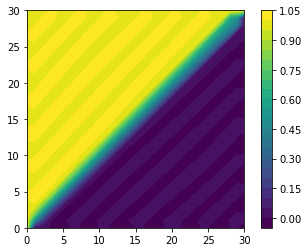

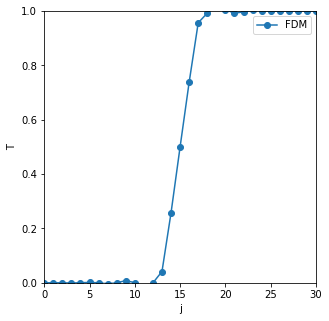

In [10]:
Tn = compute_FD(N, Pe, w = 0.01, tol= 1e-2) # Pe or Gamma, 

In [11]:
sample(N)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 1, 64]             192
            Linear-2             [-1, 1, 1, 64]           4,160
            Linear-3             [-1, 1, 1, 64]           4,160
            Linear-4             [-1, 1, 1, 64]           4,160
            Linear-5              [-1, 1, 1, 1]              65
Total params: 12,737
Trainable params: 12,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
1 1


/home/enchou/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/enchou/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/enchou/anaconda3/envs/pytorch/lib/python3.10/site-p

Epoch:  999  ,loss:  tensor(88.1652, grad_fn=<AddBackward0>)


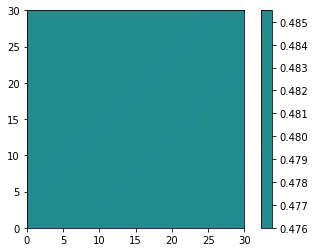

Loss curve: 


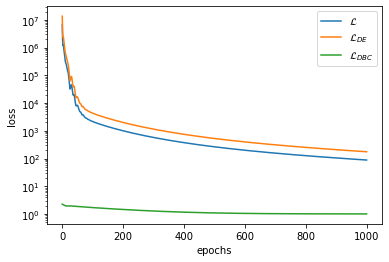

Error: 


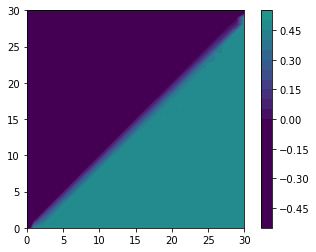

x = 0.5: 


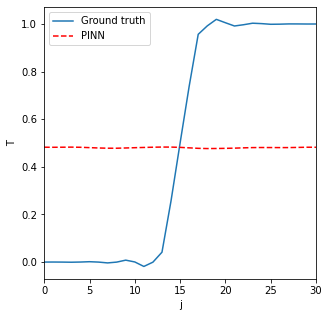

 ||||| 88.17 | 175.3 | 1.003 | 288.21 sec | 0.2309 | 0.2286 |


In [12]:
T0 = predict_NN(N, Pe, DAB = 0, train_epoch = 1000)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 1, 64]             192
            Linear-2             [-1, 1, 1, 64]           4,160
            Linear-3             [-1, 1, 1, 64]           4,160
            Linear-4             [-1, 1, 1, 64]           4,160
            Linear-5              [-1, 1, 1, 1]              65
Total params: 12,737
Trainable params: 12,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
1.2345679012345679e-10 1


/home/enchou/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/enchou/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/enchou/anaconda3/envs/pytorch/lib/python3.10/site-p

Epoch:  999  ,loss:  tensor(0.0324, grad_fn=<AddBackward0>)


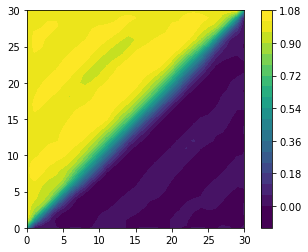

Loss curve: 


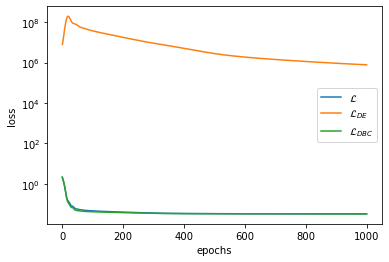

Error: 


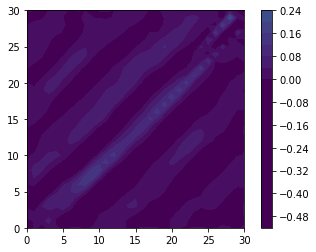

x = 0.5: 


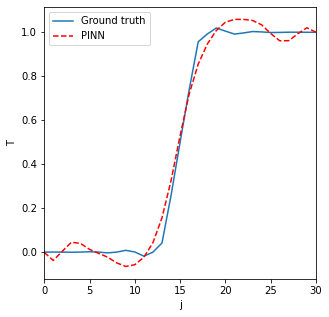

 ||||| 0.03245 | 7.804e+05 | 0.03235 | 24.35 sec | 0.002652 | 0.002162 |


In [13]:
T1 = predict_NN(N, Pe, DAB = 1, train_epoch = 1000)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 1, 64]             192
            Linear-2             [-1, 1, 1, 64]           4,160
            Linear-3             [-1, 1, 1, 64]           4,160
            Linear-4             [-1, 1, 1, 64]           4,160
            Linear-5              [-1, 1, 1, 1]              65
Total params: 12,737
Trainable params: 12,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
1.1111111111111112e-05 1


/home/enchou/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/enchou/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/enchou/anaconda3/envs/pytorch/lib/python3.10/site-p

Epoch:  999  ,loss:  tensor(0.8869, grad_fn=<AddBackward0>)


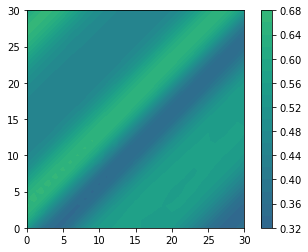

Loss curve: 


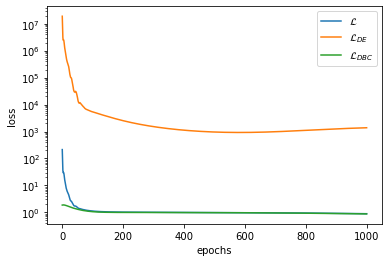

Error: 


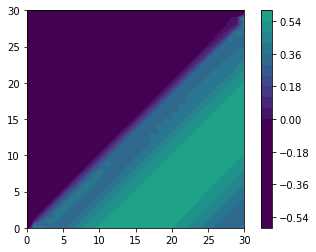

x = 0.5: 


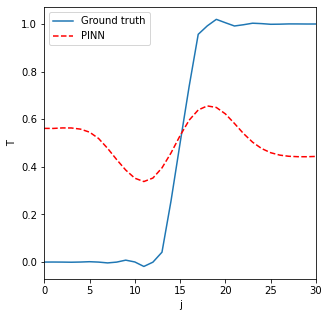

 ||||| 0.8869 | 1.378e+03 | 0.8716 | 13.44 sec | 0.2054 | 0.2096 |


In [14]:
T2 = predict_NN(N, Pe, DAB = 2, train_epoch = 1000)

x = 0.5: 


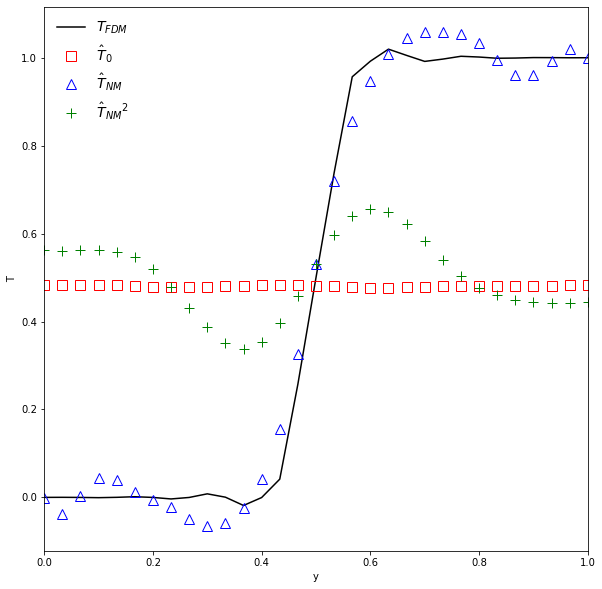

In [15]:
plotmid(Tn, T0, T1, T2, N = N)